In [1]:
import warnings

import cartopy.crs as ccrs
import eofs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import xarray as xr
from scipy.stats import circmean
from sklearn.feature_selection import mutual_info_regression

import config
from utils import plotting, processing

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# suppress warnings from cartopy about downloading data
warnings.filterwarnings("ignore", message=".*Downloading.*", module="cartopy")

In [3]:
sns.set_theme(style="darkgrid")

In [4]:
df = pd.read_csv(config.PROCESSED_DATASET_PATH, parse_dates=["timestamp"])
df.head()

storm_id           timestamp  date_angle  eat_hours  storm_total_duration  \
0      3992 2014-01-02 14:15:00    1.972603      17.25                  3.25   
1      3992 2014-01-02 14:30:00    1.972603      17.50                  3.25   
2      3992 2014-01-02 14:45:00    1.972603      17.75                  3.25   
3      3992 2014-01-02 15:00:00    1.972603      18.00                  3.25   
4      3992 2014-01-02 15:15:00    1.972603      18.25                  3.25   

         lon      lat  orography_height      anor  upslope_bearing  ...  \
0  38.900739  6.77762         2560.4673 -0.302176        18.829482  ...   
1  38.854092  6.77762         2518.0483 -0.347111        67.539908  ...   
2  38.854092  6.77762         2518.0483 -0.347111        67.539908  ...   
3  38.854092  6.77762         2518.0483 -0.347111        67.539908  ...   
4  38.806765  6.74383         2518.0483 -0.347111        67.539908  ...   

       olr_50  mean_prcp_400  min_bt  dmin_bt_dt  mean_bt  dmean_bt_dt  \
0 -272.812256       0.013373  212.28    0.000000   221.51     0.000000   
1 -272.171875       0.013495  212.31    0.000017   220.28    -0.000683   
2 -272.171875       0.013495  213.57    0.000478   221.67     0.000059   
3 -272.171875       0.012096  217.24    0.001378   223.31     0.000500   
4 -272.171875       0.008016  218.79    0.001447   224.48     0.000660   

   storm_min_bt  storm_min_bt_reached  mjo_phase  mjo_amplitude  
0        212.28                  True          5        0.43548  
1        212.28                 False          5        0.43548  
2        212.28                 False          5        0.43548  
3        212.28                 False          5        0.43548  
4        212.28                 False          5        0.43548  

[5 rows x 62 columns]

In [ ]:
# group by storm
storm_groups = df.groupby("storm_id")
storm_inits = storm_groups.first()

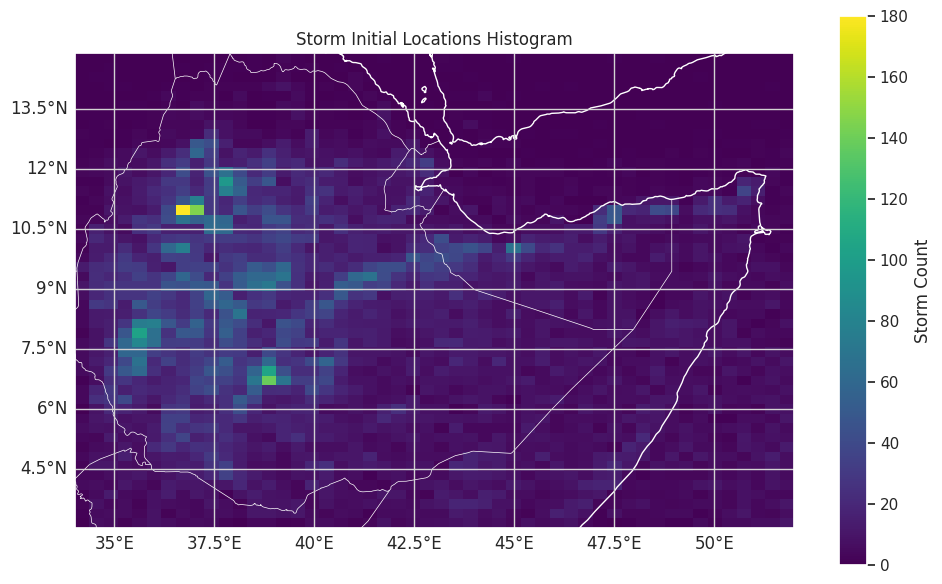

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map()
plotting.add_borders(ax, edgecolor="white")
plotting.add_gridlines(ax)

# https://www.julienphalip.com/blog/drawing-geographical-density-maps-with-matplotlib/
plt.hist2d(storm_inits["lon"], storm_inits["lat"], bins=50, cmap="viridis")
plt.colorbar(label="Storm Count")

plt.title("Storm Initial Locations Histogram")
plotting.save_plot("storm_init_hist2d.png")

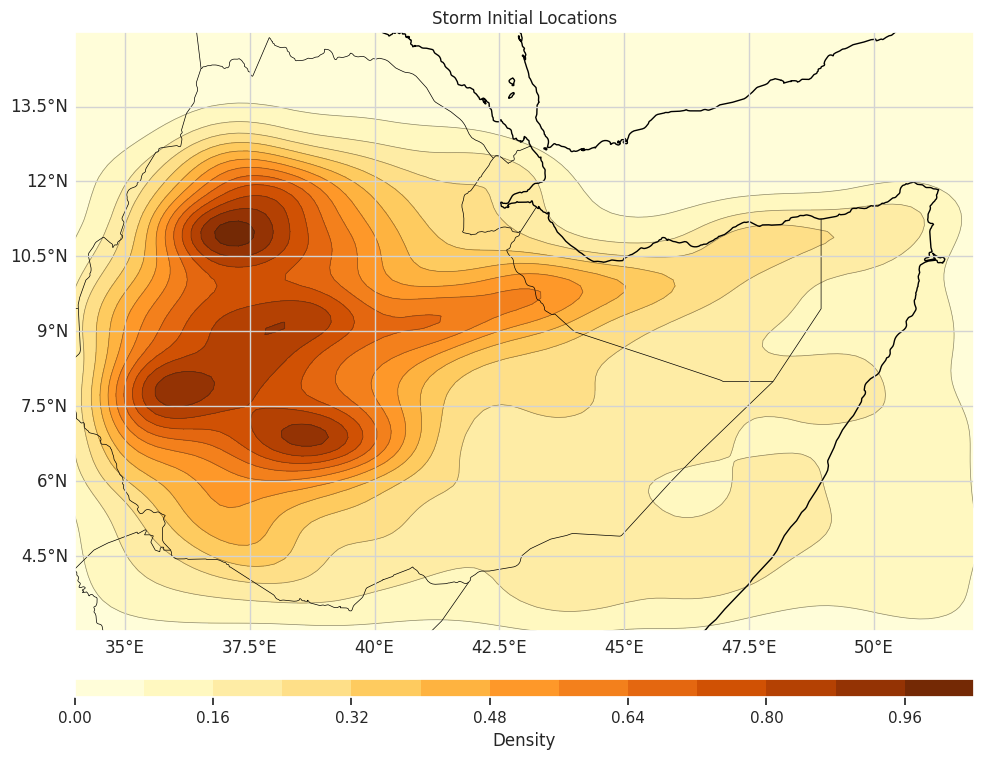

In [ ]:
# 2D kernel density estimation
X, Y, Z = processing.calc_kde(storm_inits["lon"], storm_inits["lat"])

plt.figure(figsize=(10, 10))
ax = plotting.init_map()

# add filled contours and contour lines
plotting.plot_kde_map(X, Y, Z, ax=ax, colorbar_padding=0.05)

ax.set_title("Storm Initial Locations")
plotting.save_plot("storm_init_kde.png")

In [ ]:
geop, height = processing.load_geop_and_calc_elevation()

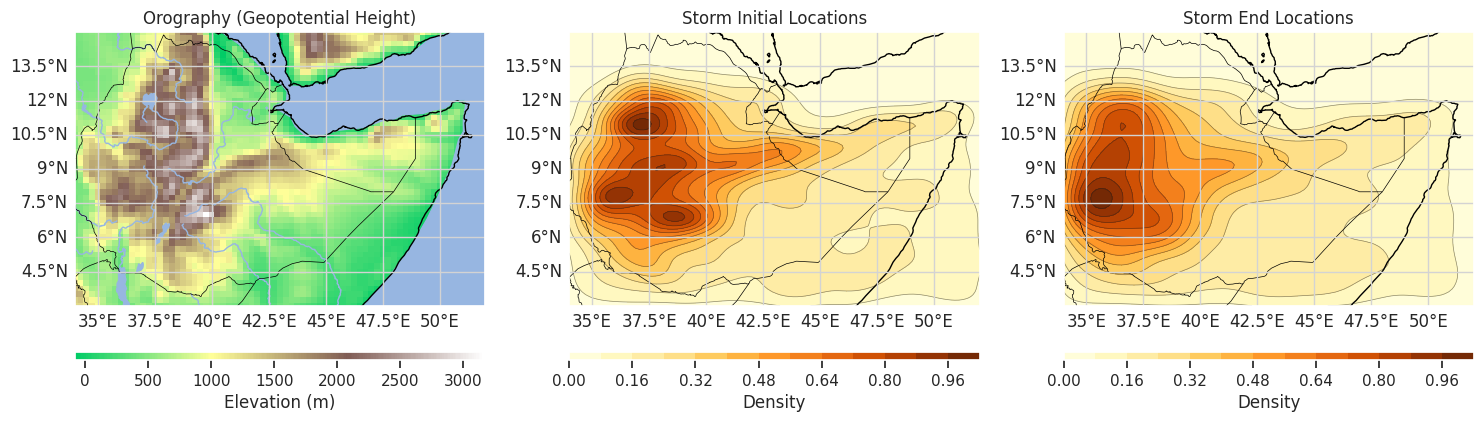

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the orography
plotting.init_map(axs[0], extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, axs[0], add_colorbar=True)
plotting.add_all_map_features(axs[0])
axs[0].set_title("Orography (Geopotential Height)")

# plot storm initial locations
storm_inits_x, storm_inits_y, storm_inits_kde = processing.calc_kde(
    storm_inits["lon"], storm_inits["lat"]
)
plotting.init_map(axs[1], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_inits_x, storm_inits_y, storm_inits_kde, ax=axs[1])
axs[1].set_title("Storm Initial Locations")

# plot storm end locations
storm_ends = storm_groups.last()
storm_ends_x, storm_ends_y, storm_ends_kde = processing.calc_kde(
    storm_ends["lon"], storm_ends["lat"]
)
plotting.init_map(axs[2], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_ends_x, storm_ends_y, storm_ends_kde, ax=axs[2])
axs[2].set_title("Storm End Locations")

plotting.save_plot("orography_storm_init_end_kde.png")

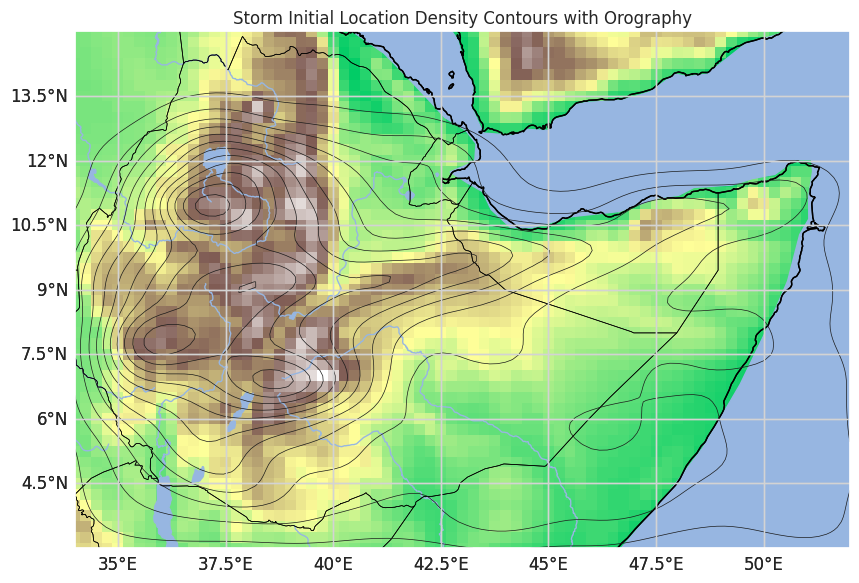

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, ax)
plotting.add_all_map_features(ax)

# plot storm initial locations kde contours
plotting.plot_kde_map(
    storm_inits_x,
    storm_inits_y,
    storm_inits_kde,
    ax=ax,
    contour_lines_only=True,
)

ax.set_title("Storm Initial Location Density Contours with Orography")
plotting.save_plot("orography_storm_init_locations.png")

In [ ]:
anor = xr.open_dataset(config.DATA_DIR / "std" / "anor.nc")

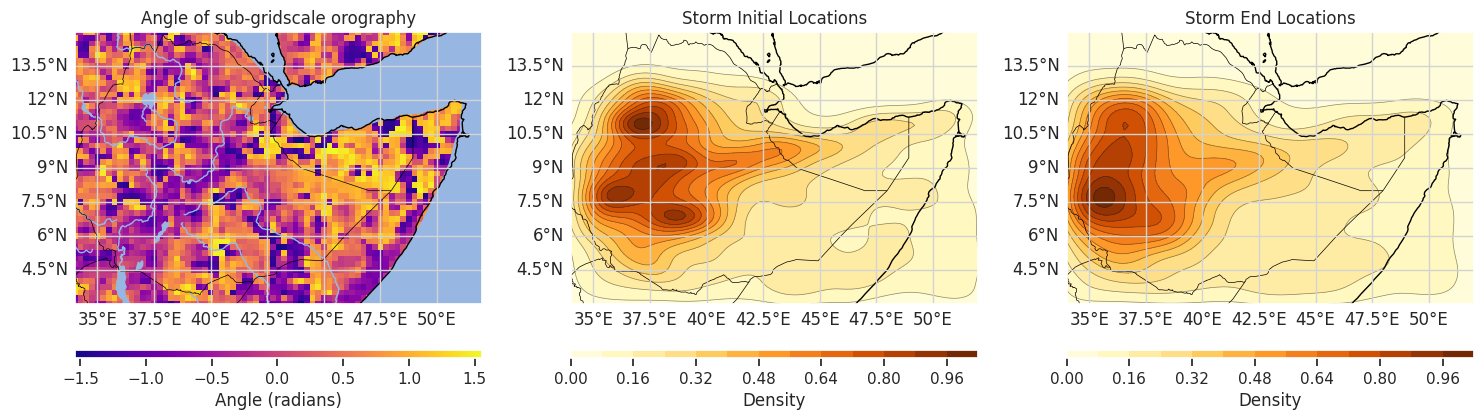

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the orography
plotting.init_map(axs[0], extent=config.STORM_DATA_EXTENT)
terrain = axs[0].pcolormesh(
    anor["longitude"],
    anor["latitude"],
    anor["anor"][0],
    cmap="plasma",
    transform=ccrs.PlateCarree(),
)
cbar = plt.colorbar(
    terrain, ax=axs[0], orientation="horizontal", pad=0.1, aspect=50
)
cbar.set_label("Angle (radians)")
plotting.add_all_map_features(axs[0])
axs[0].set_title("Angle of sub-gridscale orography")

# plot storm initial locations
storm_inits = storm_groups.first()
storm_inits_x, storm_inits_y, storm_inits_kde = processing.calc_kde(
    storm_inits["lon"], storm_inits["lat"]
)
plotting.init_map(axs[1], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_inits_x, storm_inits_y, storm_inits_kde, ax=axs[1])
axs[1].set_title("Storm Initial Locations")

# plot storm end locations
storm_ends = storm_groups.last()
storm_ends_x, storm_ends_y, storm_ends_kde = processing.calc_kde(
    storm_ends["lon"], storm_ends["lat"]
)
plotting.init_map(axs[2], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_ends_x, storm_ends_y, storm_ends_kde, ax=axs[2])
axs[2].set_title("Storm End Locations")

plotting.save_plot("anor_storm_init_end_kde.png")

In [ ]:
# group the storm inits by latitude and longitude
n_bins = 50
storm_init_2dbinned_eat_hour = storm_inits.groupby(
    [
        pd.cut(storm_inits["lat"], bins=n_bins),
        pd.cut(storm_inits["lon"], bins=n_bins),
    ],
    observed=False,
)["eat_hours"]

# find the mode and mean at each binned location
storm_init_eat_hour_mode_by_loc = storm_init_2dbinned_eat_hour.agg(
    lambda x: pd.Series.mode(x).iloc[0]
).reset_index(name="eat_hours_mode")
storm_init_eat_hour_mode_by_loc = storm_init_eat_hour_mode_by_loc.merge(
    storm_init_2dbinned_eat_hour.agg(circmean, high=24).reset_index(
        name="eat_hours_mean"
    ),
    on=["lat", "lon"],
    how="inner",
)

# convert the latitude and longitude bins to their midpoints
storm_init_eat_hour_mode_by_loc["center_lat"] = (
    storm_init_eat_hour_mode_by_loc["lat"].apply(lambda x: x.mid).astype(float)
)
storm_init_eat_hour_mode_by_loc["center_lon"] = (
    storm_init_eat_hour_mode_by_loc["lon"].apply(lambda x: x.mid).astype(float)
)

In [ ]:
storm_init_eat_hour_mode_by_loc.head()

lat               lon  eat_hours_mode  eat_hours_mean  \
0  (3.022, 3.271]  (33.998, 34.375]             NaN             NaN   
1  (3.022, 3.271]  (34.375, 34.735]            1.00       18.226829   
2  (3.022, 3.271]  (34.735, 35.095]           10.75       14.101230   
3  (3.022, 3.271]  (35.095, 35.454]           10.50        5.125000   
4  (3.022, 3.271]  (35.454, 35.814]            3.75       18.854628   

   center_lat  center_lon  
0      3.1465     34.1865  
1      3.1465     34.5550  
2      3.1465     34.9150  
3      3.1465     35.2745  
4      3.1465     35.6340

In [ ]:
# reshape the eat_hours_mode and eat_hours_mean to 2D grids
eat_mode_grid = (
    storm_init_eat_hour_mode_by_loc["eat_hours_mode"]
    .to_numpy()
    .reshape(
        n_bins,
        n_bins,
    )
)
eat_mean_grid = (
    storm_init_eat_hour_mode_by_loc["eat_hours_mean"]
    .to_numpy()
    .reshape(
        n_bins,
        n_bins,
    )
)

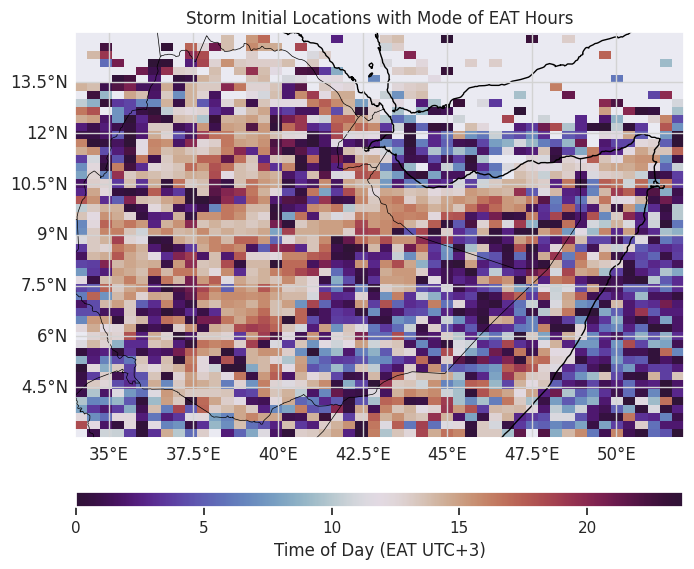

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)

pcolormesh = ax.pcolormesh(
    storm_init_eat_hour_mode_by_loc["center_lon"].unique(),
    storm_init_eat_hour_mode_by_loc["center_lat"].unique(),
    eat_mode_grid,
    cmap="twilight_shifted",
    transform=ccrs.PlateCarree(),
)
cbar = plt.colorbar(
    pcolormesh, ax=ax, orientation="horizontal", pad=0.1, aspect=40, shrink=0.63
)
cbar.set_label("Time of Day (EAT UTC+3)")
plotting.add_borders(ax)
plotting.add_gridlines(ax)

plt.title("Storm Initial Locations with Mode of EAT Hours")
plotting.save_plot("storm_init_eat_hours_mode_by_loc.png")

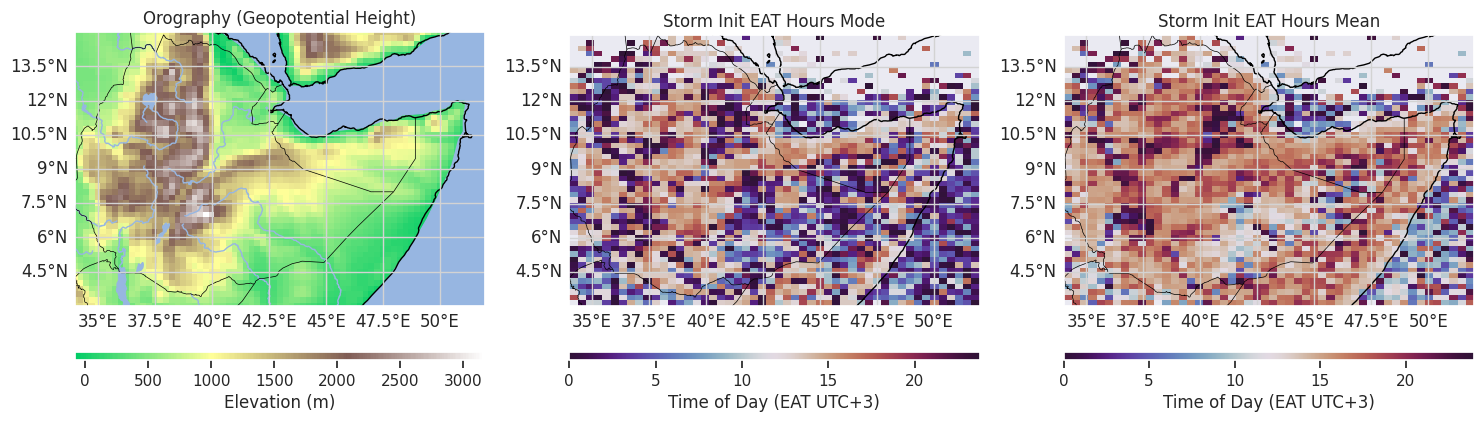

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the orography
plotting.init_map(axs[0], extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, axs[0], add_colorbar=True)
plotting.add_all_map_features(axs[0])
axs[0].set_title("Orography (Geopotential Height)")

# plot eat hours mode
pcolormesh = axs[1].pcolormesh(
    storm_init_eat_hour_mode_by_loc["center_lon"].unique(),
    storm_init_eat_hour_mode_by_loc["center_lat"].unique(),
    eat_mode_grid,
    cmap="twilight_shifted",
    transform=ccrs.PlateCarree(),
)
cbar = plt.colorbar(
    pcolormesh, ax=axs[1], orientation="horizontal", pad=0.1, aspect=50
)
cbar.set_label("Time of Day (EAT UTC+3)")
axs[1].set_title("Storm Init EAT Hours Mode")
plotting.add_borders(axs[1])
plotting.add_gridlines(axs[1])

# plot eat hours mean
pcolormesh = axs[2].pcolormesh(
    storm_init_eat_hour_mode_by_loc["center_lon"].unique(),
    storm_init_eat_hour_mode_by_loc["center_lat"].unique(),
    eat_mean_grid,
    cmap="twilight_shifted",
    transform=ccrs.PlateCarree(),
)
cbar = plt.colorbar(
    pcolormesh, ax=axs[2], orientation="horizontal", pad=0.1, aspect=50
)
cbar.set_label("Time of Day (EAT UTC+3)")
axs[2].set_title("Storm Init EAT Hours Mean")
plotting.add_borders(axs[2])
plotting.add_gridlines(axs[2])

plotting.save_plot("orography_storm_init_eat_hours_mode_mean.png")

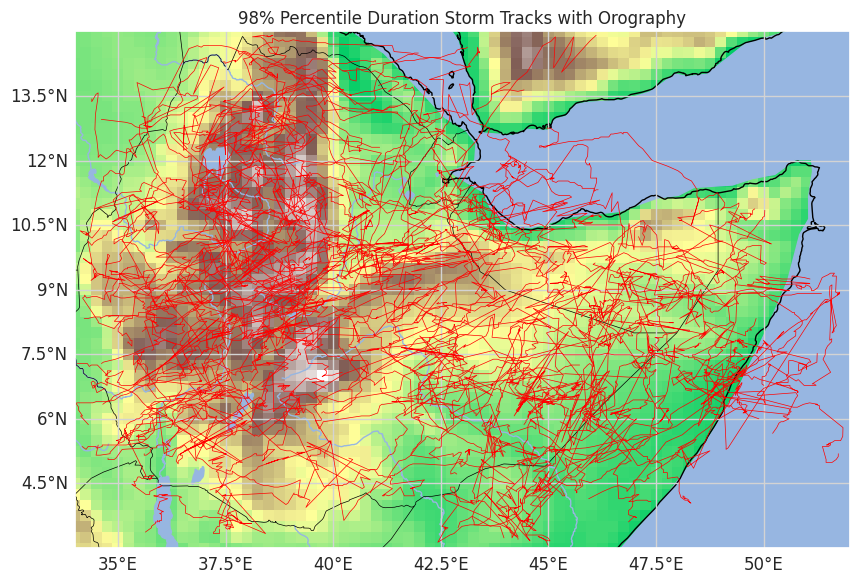

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, ax)
plotting.add_all_map_features(ax)

duration_thres = df["storm_total_duration"].quantile(0.98)
p98_duration_df = df[df["storm_total_duration"] >= duration_thres]
for storm, group in p98_duration_df.groupby("storm_id"):
    ax.plot(
        group["lon"],
        group["lat"],
        color="red",
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
    )

ax.set_title("98% Percentile Duration Storm Tracks with Orography")
plotting.save_plot("orography_storm_tracks_p98_duration.png")

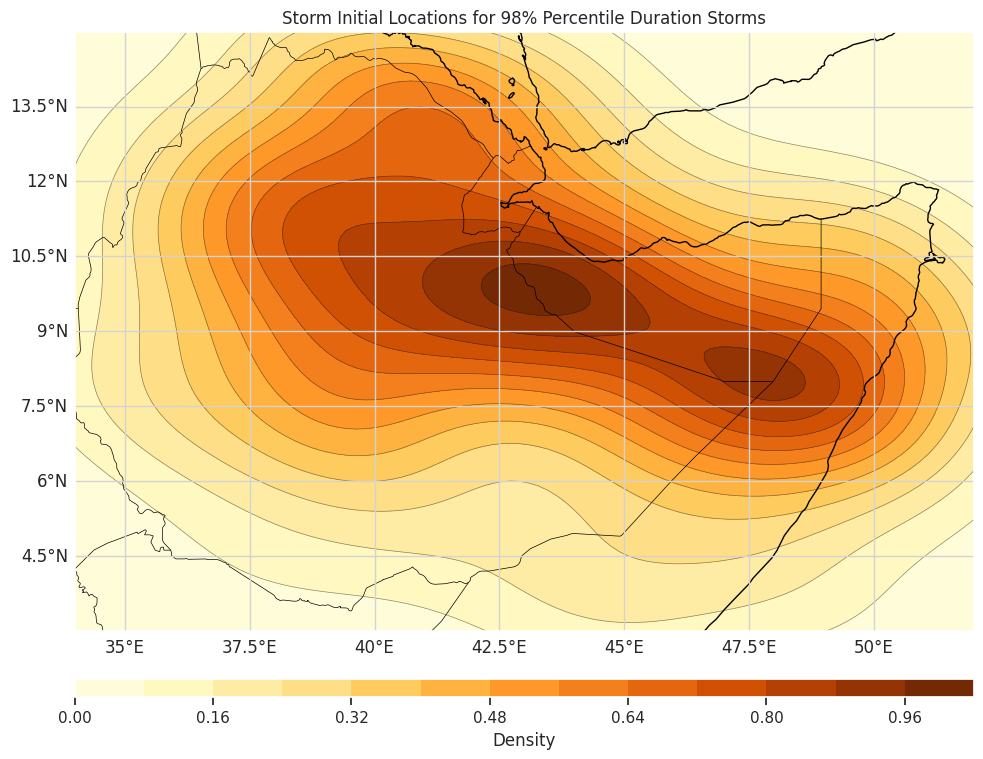

In [ ]:
# 2D kernel density estimation
p98_duration_inits = (
    p98_duration_df.sort_values(["timestamp"]).groupby("storm_id").first()
)
X, Y, Z = processing.calc_kde(
    p98_duration_inits["lon"], p98_duration_inits["lat"]
)

plt.figure(figsize=(10, 10))
ax = plotting.init_map()

# add filled contours and contour lines
plotting.plot_kde_map(X, Y, Z, ax=ax, colorbar_padding=0.05)

ax.set_title("Storm Initial Locations for 98% Percentile Duration Storms")
plotting.save_plot("p98_duration_storm_init_kde.png")

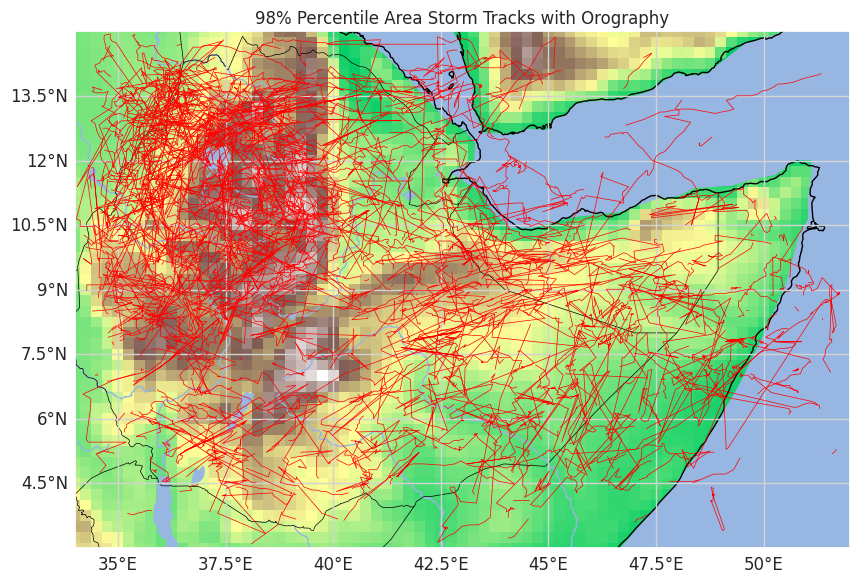

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, ax)
plotting.add_all_map_features(ax)

area_thres = df["area"].quantile(0.98)
p98_area_df = df[df["area"] >= area_thres]
for storm, group in p98_area_df.groupby("storm_id"):
    ax.plot(
        group["lon"],
        group["lat"],
        color="red",
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
    )

ax.set_title("98% Percentile Area Storm Tracks with Orography")
plotting.save_plot("orography_storm_tracks_p98_area.png")

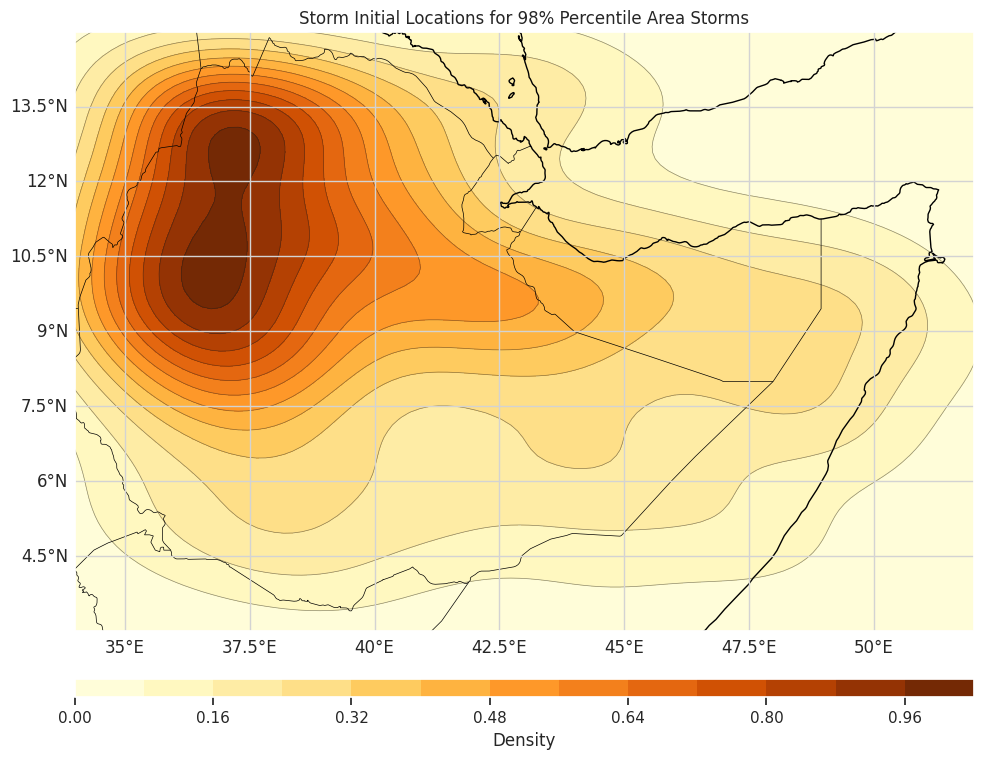

In [ ]:
# 2D kernel density estimation
p98_area_inits = (
    p98_area_df.sort_values(["timestamp"]).groupby("storm_id").first()
)
X, Y, Z = processing.calc_kde(p98_area_inits["lon"], p98_area_inits["lat"])

plt.figure(figsize=(10, 10))
ax = plotting.init_map()

# add filled contours and contour lines
plotting.plot_kde_map(X, Y, Z, ax=ax, colorbar_padding=0.05)

ax.set_title("Storm Initial Locations for 98% Percentile Area Storms")
plotting.save_plot("p98_area_storm_init_kde.png")

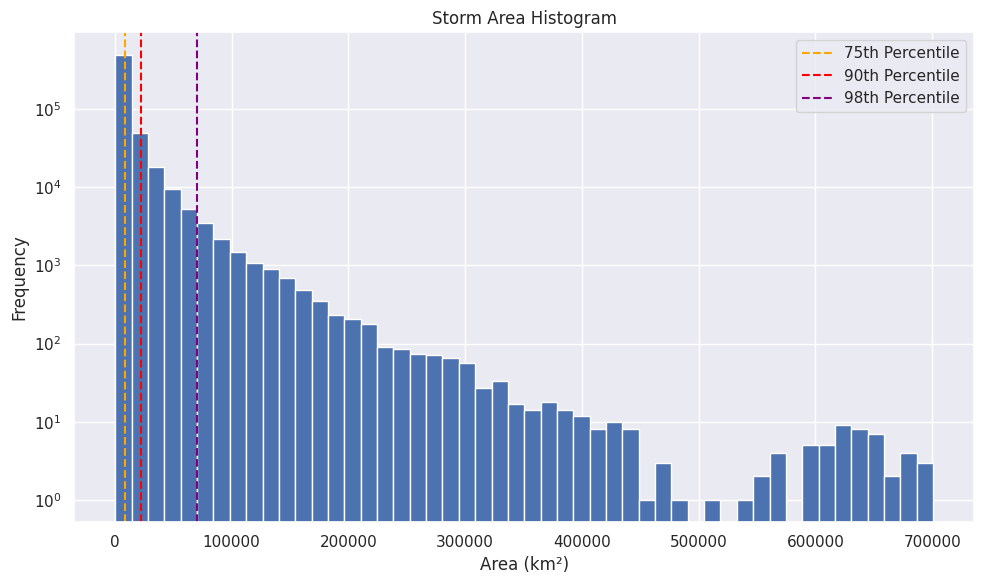

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["area"], bins=50)
plt.yscale("log")

# plot vertical lines for 75, 90, and 98th percentiles
plt.axvline(
    df["area"].quantile(0.75),
    color="orange",
    linestyle="--",
    label="75th Percentile",
)
plt.axvline(
    df["area"].quantile(0.90),
    color="red",
    linestyle="--",
    label="90th Percentile",
)
plt.axvline(
    df["area"].quantile(0.98),
    color="purple",
    linestyle="--",
    label="98th Percentile",
)
plt.legend()

plt.xlabel("Area (km²)")
plt.ylabel("Frequency")
plt.title("Storm Area Histogram")
plotting.save_plot("storm_area_hist.png")

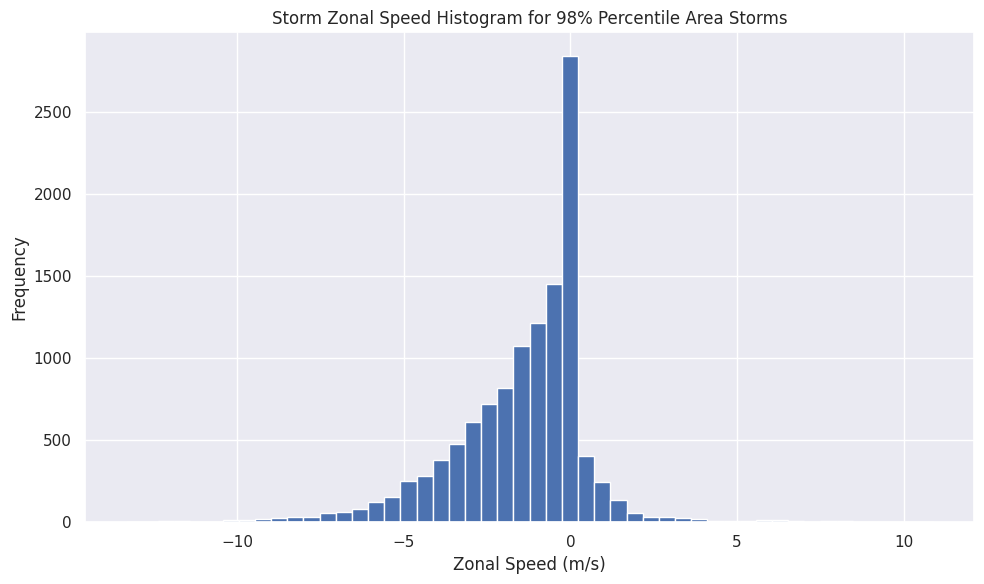

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(p98_area_df["zonal_speed"], bins=50)
plt.xlabel("Zonal Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Zonal Speed Histogram for 98% Percentile Area Storms")
plotting.save_plot("p98_area_storm_zonal_speed_hist.png")

In [ ]:
degrees_to_cardinal_map = {
    90: "E",
    67.5: "ENE",
    45: "NE",
    22.5: "NNE",
    0: "N",
    337.5: "NNW",
    315: "NW",
    292.5: "WNW",
    270: "W",
    247.5: "WSW",
    225: "SW",
    202.5: "SSW",
    180: "S",
    157.5: "SSE",
    135: "SE",
    112.5: "ESE",
}
cardinal_directions = list(degrees_to_cardinal_map.values())

In [ ]:
# convert storm bearing to closest cardinal direction
df["storm_closest_cardinal_direction"] = (
    ((df["storm_bearing"] % 360) + (22.5 / 2)).floordiv(22.5) * 22.5 % 360
)
df["storm_closest_cardinal_direction"] = (
    df["storm_closest_cardinal_direction"]
    .map(degrees_to_cardinal_map)
    .astype("category")
)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(
        r=df["storm_closest_cardinal_direction"].value_counts(normalize=True)[
            cardinal_directions
        ],
        theta=cardinal_directions,
        fill="toself",
        name="All Storms",
    )
)
p98_area_df = df[df["storm_max_area"] >= area_thres]
fig.add_trace(
    go.Scatterpolar(
        r=p98_area_df["storm_closest_cardinal_direction"].value_counts(
            normalize=True
        )[cardinal_directions],
        theta=cardinal_directions,
        fill="toself",
        name="98% Percentile Max Area Storms",
    )
)
p98_duration_df = df[df["storm_total_duration"] >= duration_thres]
fig.add_trace(
    go.Scatterpolar(
        r=p98_duration_df["storm_closest_cardinal_direction"].value_counts(
            normalize=True
        )[cardinal_directions],
        theta=cardinal_directions,
        fill="toself",
        name="98% Percentile Duration Storms",
    )
)
p98_min_bt_df = df[df["storm_min_bt"] <= df["storm_min_bt"].quantile(0.02)]
fig.add_trace(
    go.Scatterpolar(
        r=p98_min_bt_df["storm_closest_cardinal_direction"].value_counts(
            normalize=True
        )[cardinal_directions],
        theta=cardinal_directions,
        fill="toself",
        name="98% Percentile Min BT Storms",
    )
)

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
        )
    ),
    showlegend=True,
    title="Storm Cardinal Directions Distribution",
)

fig.show()

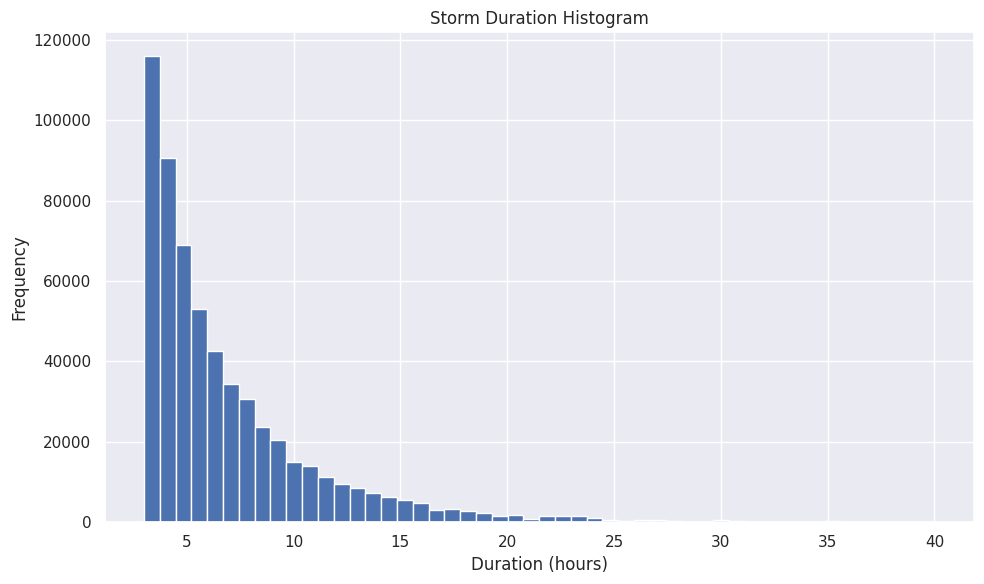

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["storm_total_duration"], bins=50)

plt.xlabel("Duration (hours)")
plt.ylabel("Frequency")
plt.title("Storm Duration Histogram")
plotting.save_plot("storm_duration_hist.png")

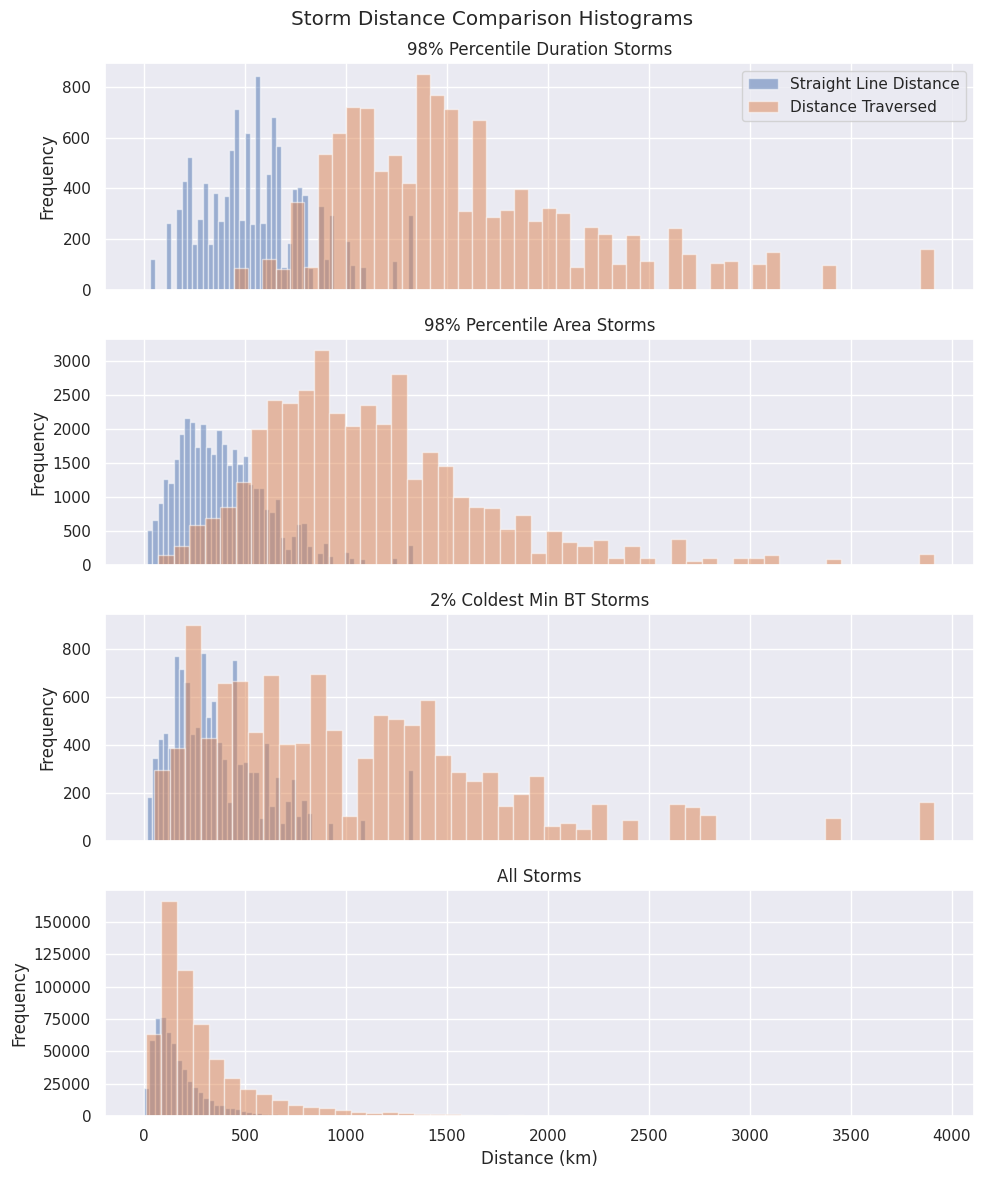

In [43]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 98th percentile duration storms
axs[0].hist(
    p98_duration_df["storm_straight_line_distance"],
    bins=50,
    alpha=0.5,
    label="Straight Line Distance",
)
axs[0].hist(
    p98_duration_df["storm_distance_traversed"],
    bins=50,
    alpha=0.5,
    label="Distance Traversed",
)
axs[0].set_ylabel("Frequency")
axs[0].set_title("98% Percentile Duration Storms")
axs[0].legend()

# 98th percentile area storms
axs[1].hist(
    p98_area_df["storm_straight_line_distance"],
    bins=50,
    alpha=0.5,
    label="Straight Line Distance",
)
axs[1].hist(
    p98_area_df["storm_distance_traversed"],
    bins=50,
    alpha=0.5,
    label="Distance Traversed",
)
axs[1].set_ylabel("Frequency")
axs[1].set_title("98% Percentile Area Storms")

# 2% lowest storm_min_bt storms
min_bt_thres = df["storm_min_bt"].quantile(0.02)
p98_min_bt_df = df[df["storm_min_bt"] <= min_bt_thres]
axs[2].hist(
    p98_min_bt_df["storm_straight_line_distance"],
    bins=50,
    alpha=0.5,
    label="Straight Line Distance",
)
axs[2].hist(
    p98_min_bt_df["storm_distance_traversed"],
    bins=50,
    alpha=0.5,
    label="Distance Traversed",
)

axs[2].set_ylabel("Frequency")
axs[2].set_title("2% Coldest Min BT Storms")

# All storms
axs[3].hist(
    df["storm_straight_line_distance"],
    bins=50,
    alpha=0.5,
    label="Straight Line Distance",
)
axs[3].hist(
    df["storm_distance_traversed"],
    bins=50,
    alpha=0.5,
    label="Distance Traversed",
)
axs[3].set_ylabel("Frequency")
axs[3].set_xlabel("Distance (km)")
axs[3].set_title("All Storms")

plt.suptitle("Storm Distance Comparison Histograms")

plt.tight_layout()
plotting.save_plot("storm_distance_hist_subplots.png")

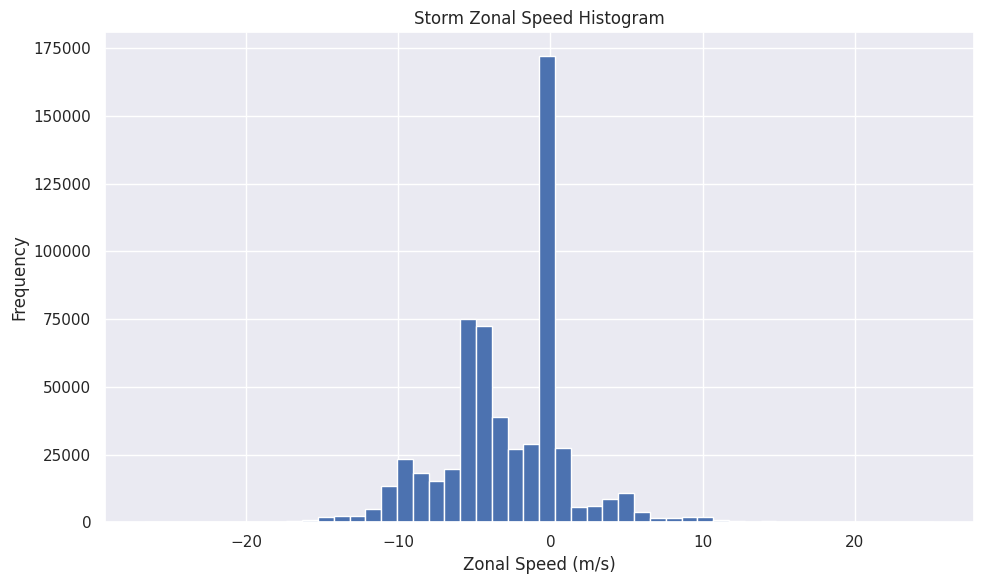

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["zonal_speed"], bins=50)

plt.xlabel("Zonal Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Zonal Speed Histogram")
plotting.save_plot("storm_zonal_speed_hist.png")

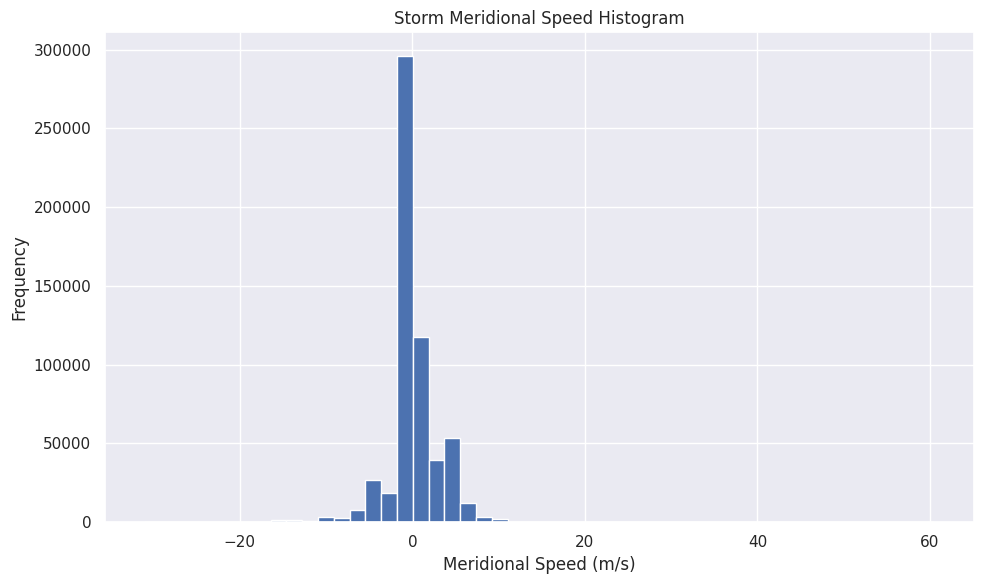

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["meridional_speed"], bins=50)

plt.xlabel("Meridional Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Meridional Speed Histogram")
plotting.save_plot("storm_meridional_speed_hist.png")

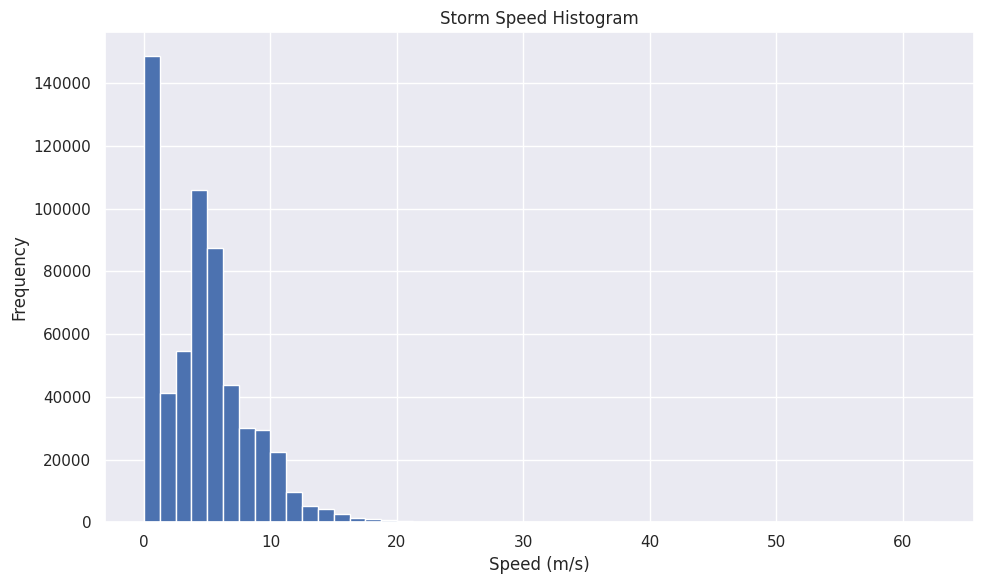

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt(df["zonal_speed"] ** 2 + df["meridional_speed"] ** 2), bins=50)

plt.xlabel("Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Speed Histogram")
plotting.save_plot("storm_speed_hist.png")

In [7]:
df_corr = df.corr()

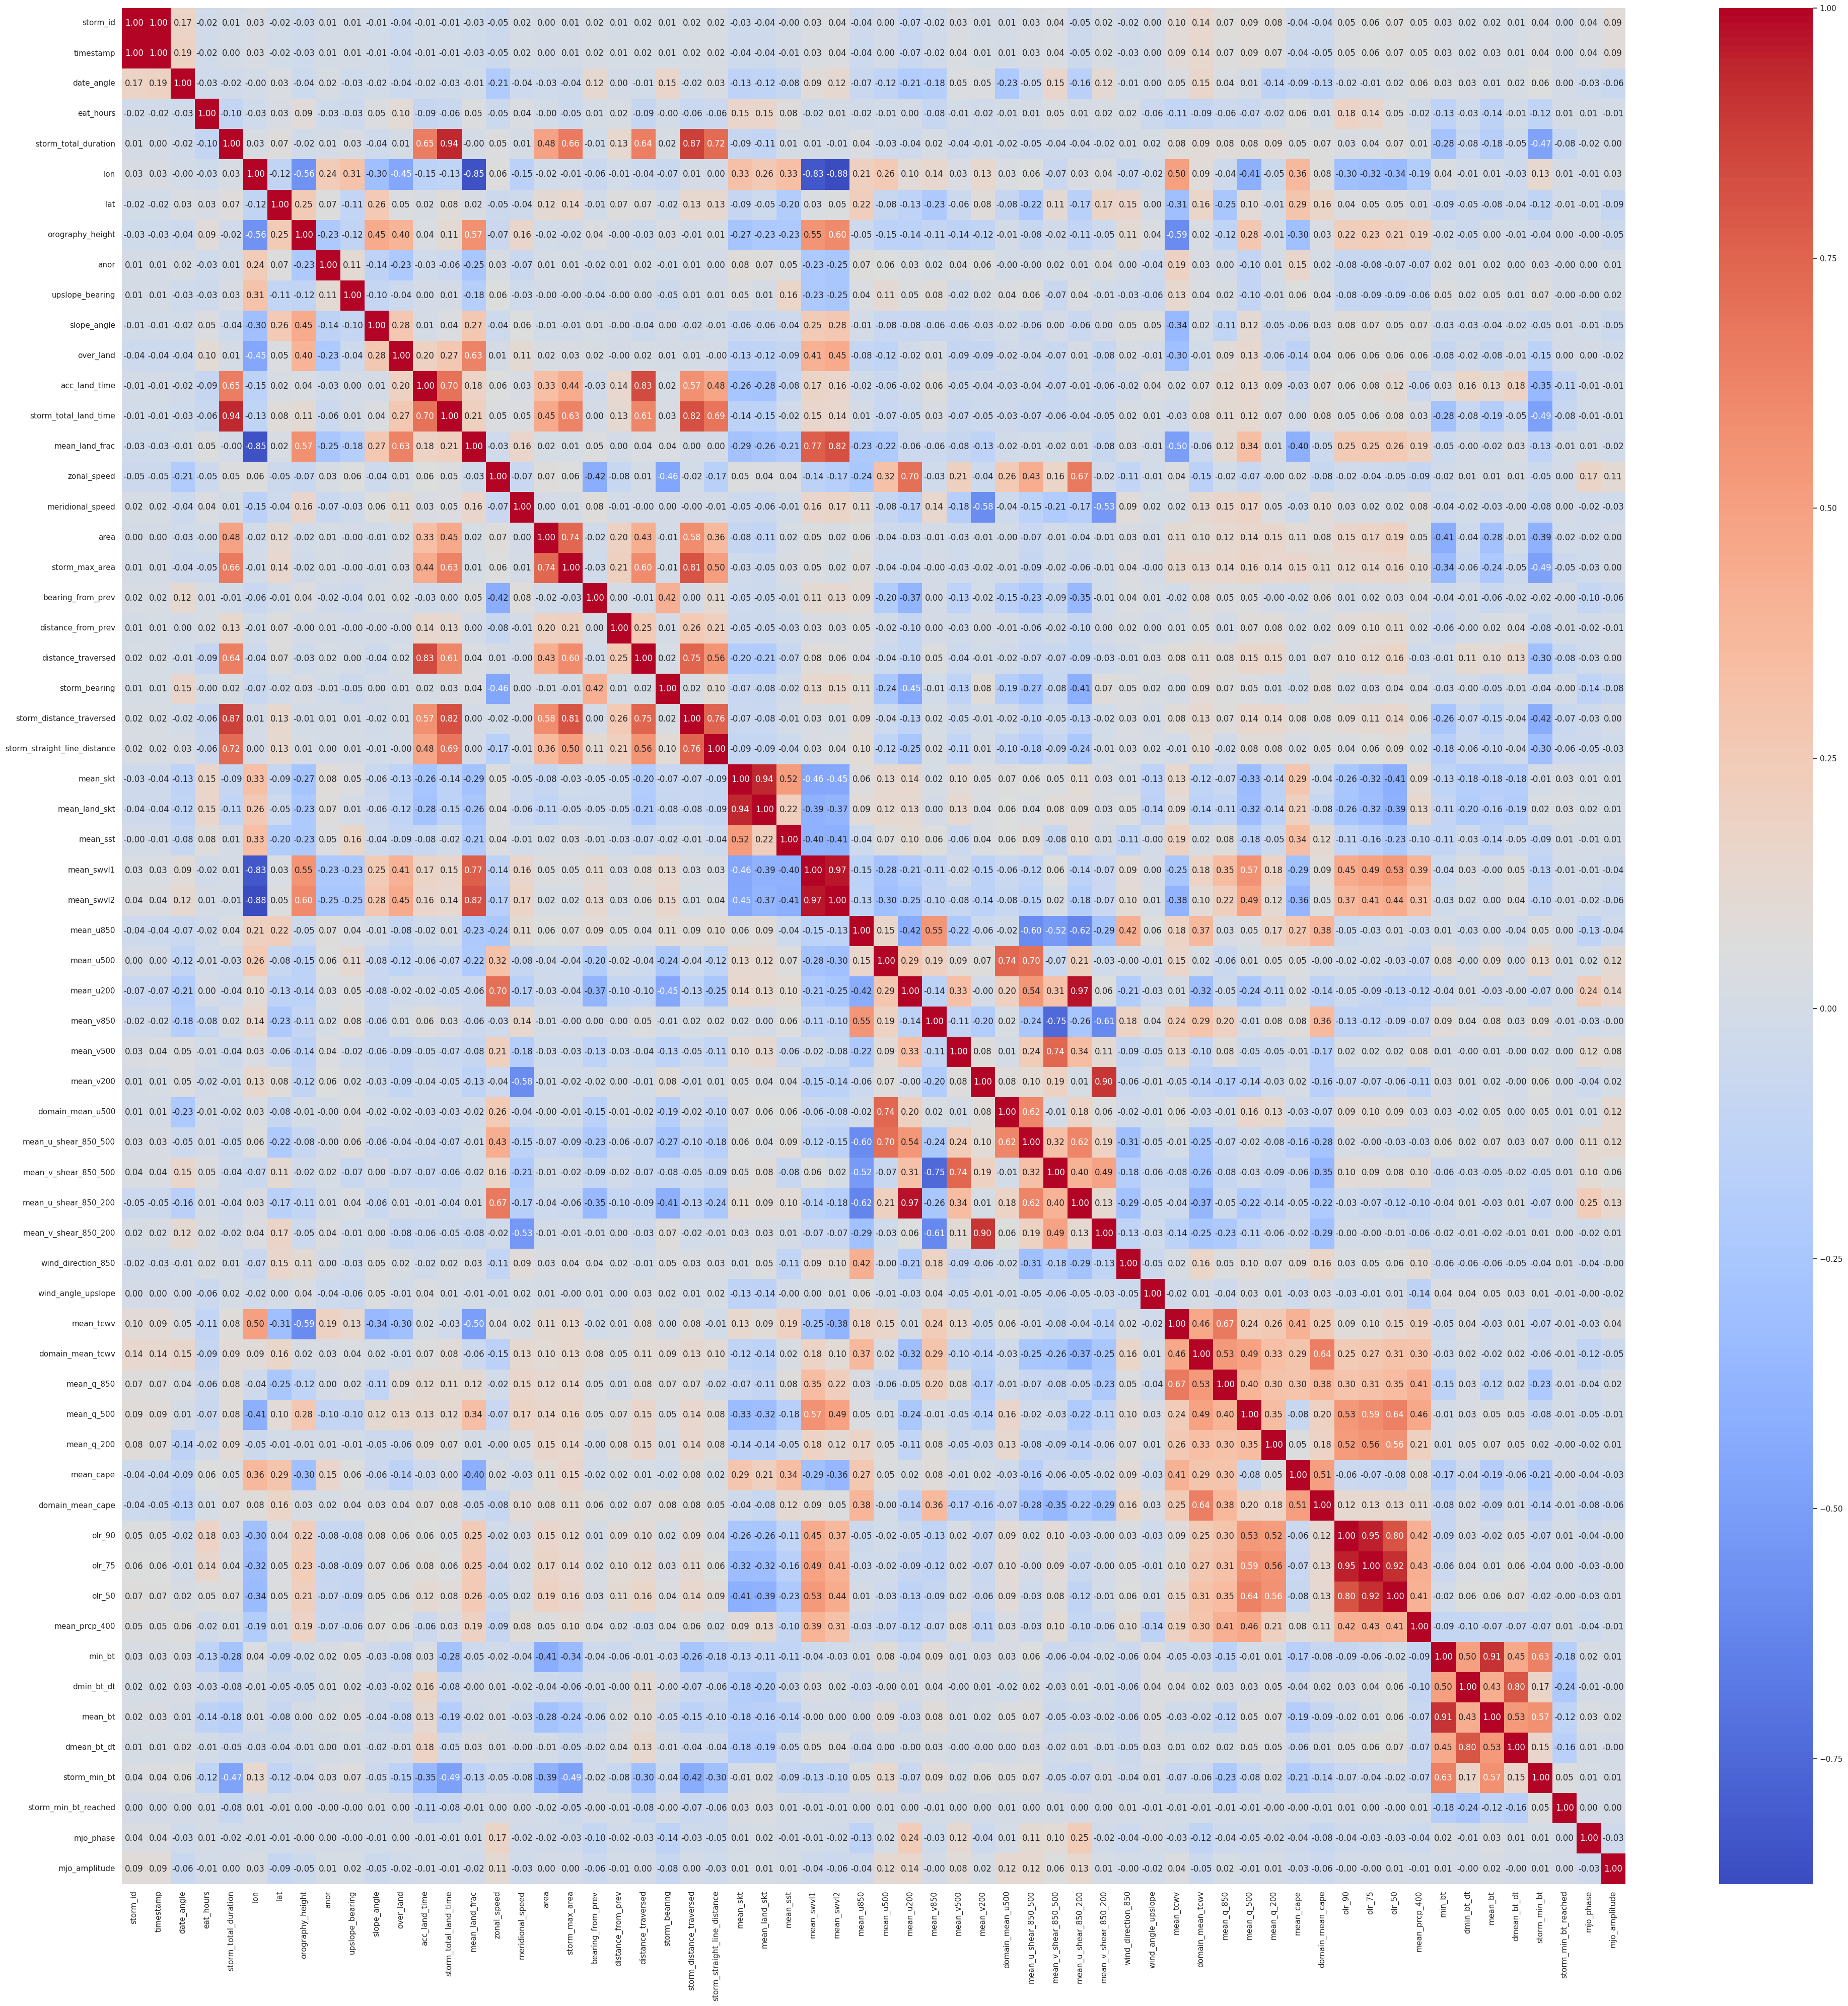

In [10]:
plt.figure(figsize=(40, 40))
sns.heatmap(
    df_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
)
plotting.save_plot("feature_correlation_heatmap.png")

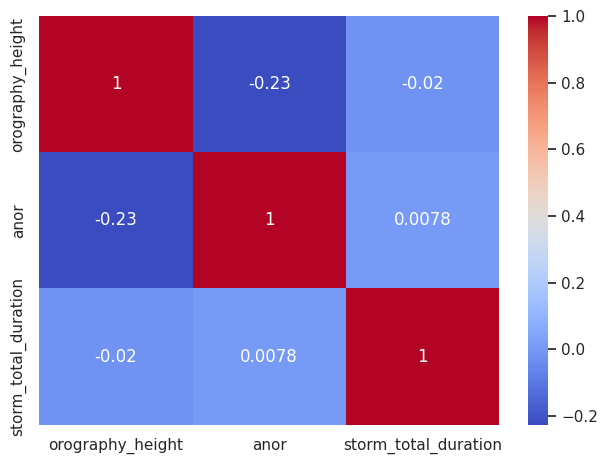

In [ ]:
sns.heatmap(
    df[["orography_height", "anor", "storm_total_duration"]].corr(),
    annot=True,
    cmap="coolwarm",
)
plotting.save_plot("orography_anor_correlation_heatmap.png")

In [ ]:
sns.heatmap(
    df.corr(
        method=lambda x, y: mutual_info_regression(
            x.reshape(-1, 1), y, discrete_features=False
        )[0]
    ),
    annot=True,
    cmap="coolwarm",
)
plotting.save_plot("mutual_info_heatmap.png")

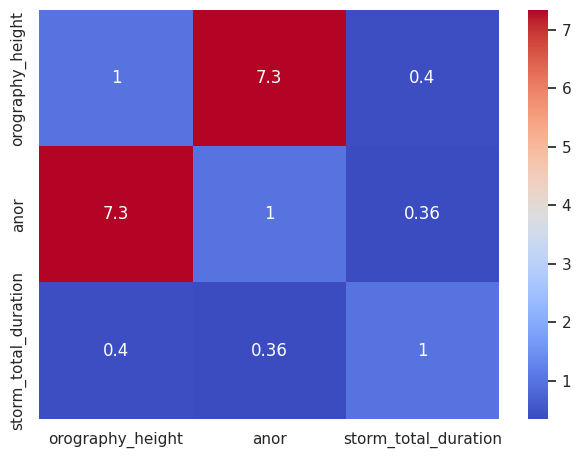

In [ ]:
sns.heatmap(
    df[["orography_height", "anor", "storm_total_duration"]].corr(
        method=lambda x, y: mutual_info_regression(
            x.reshape(-1, 1), y, discrete_features=False
        )[0]
    ),
    annot=True,
    cmap="coolwarm",
)
plotting.save_plot("orography_anor_mutual_info_heatmap.png")

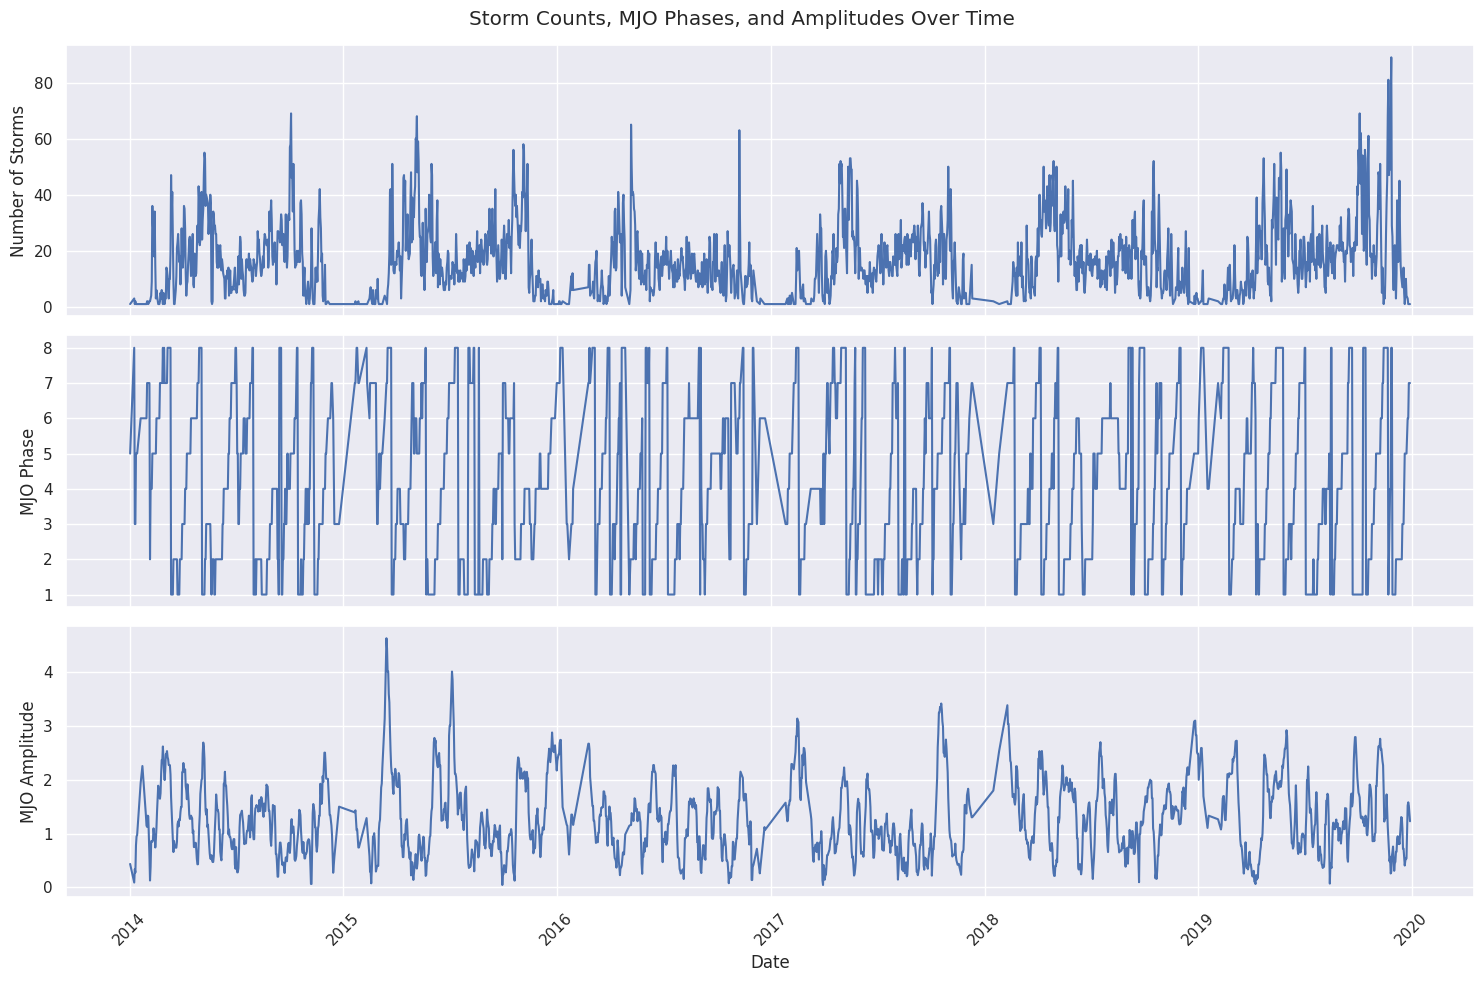

In [ ]:
df["date"] = pd.to_datetime(df["timestamp"]).dt.date
storm_counts = df.groupby("date")["storm_id"].nunique().reset_index()
storm_counts.columns = ["date", "storm_count"]

fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
sns.lineplot(data=storm_counts, x="date", y="storm_count", ax=axs[0])
axs[0].set_ylabel("Number of Storms")

mjo_phases = df.groupby("date")["mjo_phase"].first().reset_index()
sns.lineplot(data=mjo_phases, x="date", y="mjo_phase", ax=axs[1])
axs[1].set_ylabel("MJO Phase")

mjo_ampls = df.groupby("date")["mjo_amplitude"].first().reset_index()
sns.lineplot(data=mjo_ampls, x="date", y="mjo_amplitude", ax=axs[2])
axs[2].set_ylabel("MJO Amplitude")
plt.xticks(rotation=45)
plt.xlabel("Date")

plt.suptitle("Storm Counts, MJO Phases, and Amplitudes Over Time")

plotting.save_plot("storm_counts_per_day_vs_mjo.png")

In [ ]:
df["over_land"] = df["over_land"].astype(int)
df["storm_min_bt_reached"] = df["storm_min_bt_reached"].astype(int)

In [ ]:
# interpolate all storms to have 11 points each
# 11 ensures that there are points at 0%, 100%, and 10% intervals
n_points = 11
storm_10_points_df = processing.interpolate_all_storms(df, n_points=n_points)

In [ ]:
# reshape the min_bt column to a 2D array with shape (num_storms, n_points)
min_bt_by_storm_arr = (
    storm_10_points_df["min_bt"]
    .to_numpy()
    .reshape(storm_10_points_df["storm_id"].nunique(), n_points)
)

In [ ]:
# perform EOF analysis on the minimum BT by storm
solver = eofs.standard.Eof(min_bt_by_storm_arr)
pcs = solver.pcs(pcscaling=0)  # 0 means unscaled pcs
eofs_list = eofs_list = solver.eofs(
    neofs=10, eofscaling=1
)  # 1 means normalised EOF(divided by the square-root of their eignevalues)
variance_fractions = solver.varianceFraction()

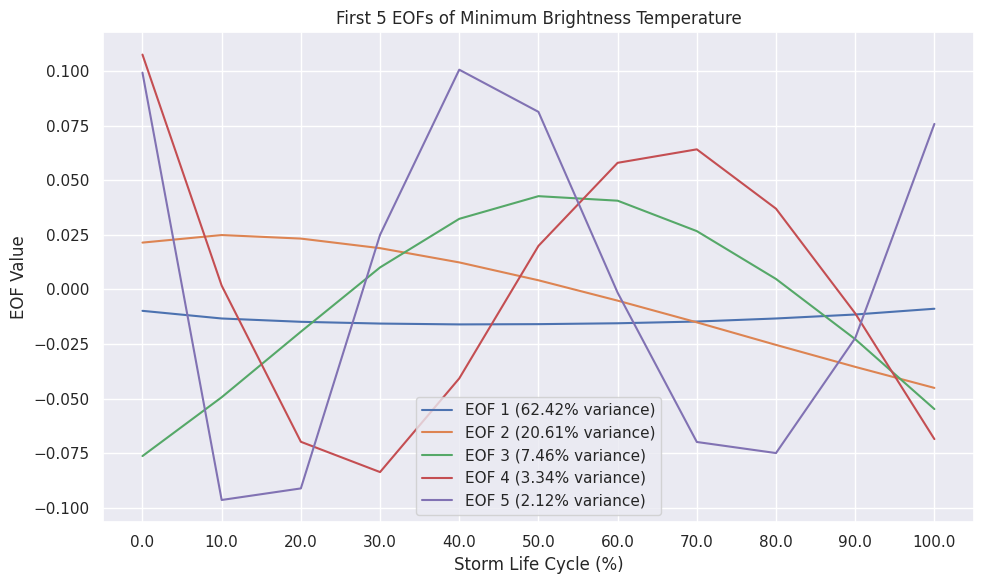

In [ ]:
# plot the first 5 EOFs
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(
        eofs_list[i, :],
        label=f"EOF {i + 1} ({variance_fractions[i] * 100:.2f}% variance)",
    )
plt.xlabel("Storm Life Cycle (%)")
plt.xticks(
    np.arange(0, n_points, 1),
    labels=[f"{round(x/10, 2)*100}" for x in range(0, n_points)],
)
plt.ylabel("EOF Value")
plt.title("First 5 EOFs of Minimum Brightness Temperature")
plt.legend()
plotting.save_plot("eofs_min_bt.png")

In [ ]:
# get the first point of each storm
storm_first_points = storm_10_points_df.groupby("storm_id").first()

# create land/sea groups
land_storms = storm_first_points[storm_first_points["over_land"] == True].index
sea_storms = storm_first_points[storm_first_points["over_land"] == False].index

# create time groups (nighttime: < 8 or >= 20, daytime: 8 <= eat_hours < 20)
night_storms = storm_first_points[
    (storm_first_points["eat_hours"] < 8)
    | (storm_first_points["eat_hours"] >= 20)
].index
day_storms = storm_first_points[
    (storm_first_points["eat_hours"] >= 8)
    & (storm_first_points["eat_hours"] < 20)
].index

# Add group labels to the interpolated dataset
storm_10_points_df["land_init"] = storm_10_points_df["storm_id"].isin(
    land_storms
)
storm_10_points_df["night_init"] = storm_10_points_df["storm_id"].isin(
    night_storms
)

In [ ]:
land_init_points = storm_10_points_df[storm_10_points_df["land_init"] == True]
land_init_min_bt_mean = (
    land_init_points["min_bt"]
    .to_numpy()
    .reshape(land_init_points["storm_id"].nunique(), n_points)
    .mean(axis=0)
)

sea_init_points = storm_10_points_df[storm_10_points_df["land_init"] == False]
sea_init_min_bt_mean = (
    sea_init_points["min_bt"]
    .to_numpy()
    .reshape(sea_init_points["storm_id"].nunique(), n_points)
    .mean(axis=0)
)
day_init_points = storm_10_points_df[storm_10_points_df["night_init"] == False]
day_init_min_bt_mean = (
    day_init_points["min_bt"]
    .to_numpy()
    .reshape(day_init_points["storm_id"].nunique(), n_points)
    .mean(axis=0)
)
night_init_points = storm_10_points_df[storm_10_points_df["night_init"] == True]
night_init_min_bt_mean = (
    night_init_points["min_bt"]
    .to_numpy()
    .reshape(night_init_points["storm_id"].nunique(), n_points)
    .mean(axis=0)
)

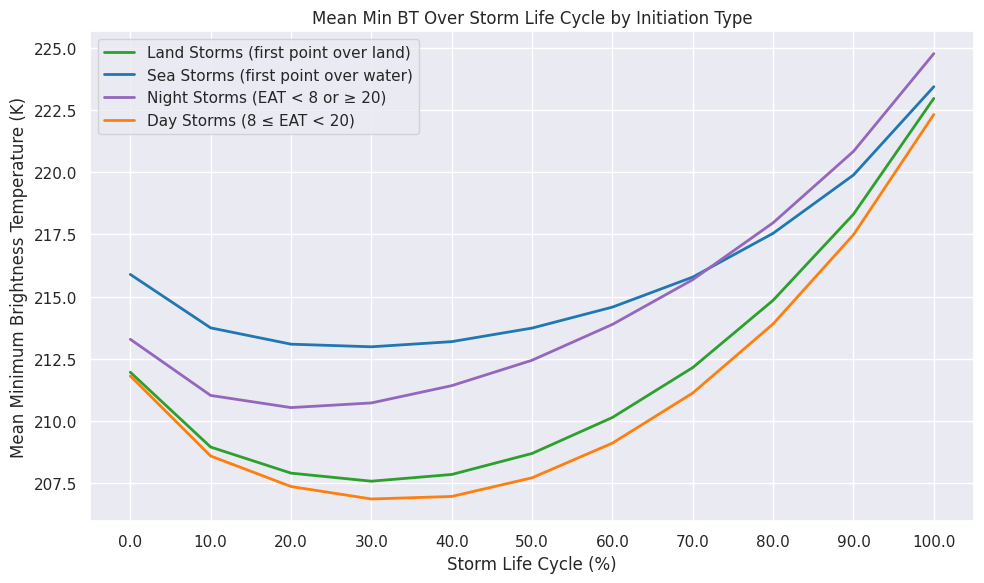

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot the mean minimum brightness temperature over the storm life cycle
ax.plot(
    land_init_min_bt_mean,
    "tab:green",
    linewidth=2,
    label="Land Storms (first point over land)",
)
ax.plot(
    sea_init_min_bt_mean,
    "tab:blue",
    linewidth=2,
    label="Sea Storms (first point over water)",
)
ax.plot(
    night_init_min_bt_mean,
    "tab:purple",
    linewidth=2,
    label="Night Storms (EAT < 8 or ≥ 20)",
)
ax.plot(
    day_init_min_bt_mean,
    "tab:orange",
    linewidth=2,
    label="Day Storms (8 ≤ EAT < 20)",
)
ax.set_xlabel("Storm Life Cycle (%)")
ax.set_xticks(
    np.arange(0, n_points, 1),
    labels=[f"{round(x/10, 2)*100}" for x in range(0, n_points)],
)
ax.set_ylabel("Mean Minimum Brightness Temperature (K)")
ax.set_title("Mean Min BT Over Storm Life Cycle by Initiation Type")
ax.legend()

plt.tight_layout()
plotting.save_plot("min_bt_over_lifecycle_by_init_type.png")